# Explaining Probability of Improvement
> From the ground up!

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

In [1]:
from math import sqrt
SPINE_COLOR = 'gray'

In [2]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

In [3]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

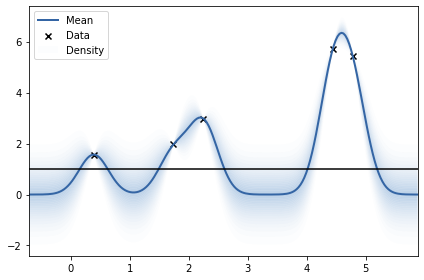

In [4]:
f = lambda x: 0.4*x**2 - 0.15*x**3 + 0.5*x**2 - 0.002*x**5 + 0.0002*x**6 +0.5*(x-2)**2

np.random.seed(0)
# 30 equally spaced sample locations 
X = np.linspace(0.05, 4.95, 30)[:,None]

np.random.shuffle(X)

# y = f(X) + epsilon
Y = f(X) + np.random.normal(0., 0.1, (30,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

train_X = X[:5]
train_Y = Y[:5]

test_X = X[5:]
test_Y = Y[5:]




ls = [0.05, 0.25, 0.5, 1., 2., 4.]
from sklearn.metrics import mean_absolute_error


iteration = 1

k = GPy.kern.RBF(1)
k.lengthscale = ls[iteration]
m = GPy.models.GPRegression(train_X, train_Y, k)
m.Gaussian_noise = 0.0
m.plot(plot_density=True)
plt.axhline(1, color='k')


In [5]:
X2  = np.linspace(0.05, 4.95, 10000)[:,None]
mu, var = m.predict(X2)
mu = mu.squeeze()
std = np.sqrt(var).squeeze()
x = X2.flatten()

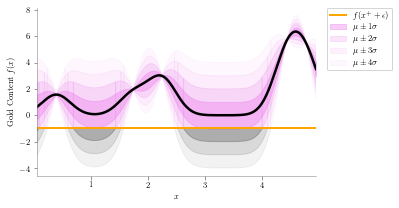

In [6]:
latexify(fig_width=5)
y_max_eps = -1

plt.plot(X2, mu, color='k', mew=2, lw=2.5)

alphas = {1:0.4, 2:0.2, 3:0.1, 4:0.05}
labels = {x:r'$\mu \pm %s\sigma$' %x for x in [1, 2, 3, 4]}
def plot_gray(n):
    y1 = mu-n*std
    y2 = mu+n*std
    y_temp = y_max_eps*np.ones_like(y1)
    plt.fill_between(x,y1,y2,where=y1>y_temp,color='violet',alpha=alphas[n], interpolate=True, label=labels[n])
    plt.fill_between(x,y_temp,y2,where=y1<=y_temp,color='violet',alpha=alphas[n], interpolate=True)
    plt.fill_between(x,y1,y_temp,where=y1<=y_temp,color='black', alpha=alphas[n], interpolate=True)
    #plt.fill_between(x,y1,y_temp,where=y1<=y_temp,color='black', alpha=1, interpolate=True)



plot_gray(1)

plot_gray(2)
plot_gray(3)
plot_gray(4)




plt.axhline(y_max_eps, color='orange', mew=2, lw=2, label=r'$f(x^+ + \epsilon)$')

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.xlabel("$x$")
plt.ylabel(r"Gold Content $f(x)$")
plt.xlim((x.min(), x.max()))
format_axes(plt.gca())